In [199]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time  
import botorch
from botorch.models import MultiTaskGP, SingleTaskGP, ModelList
from botorch.models.transforms.outcome import OutcomeTransform, Standardize
from botorch.models.transforms.input import InputTransform, Normalize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model, fit_gpytorch_mll
from botorch.acquisition.multi_objective import qNoisyExpectedHypervolumeImprovement
from botorch.optim import optimize_acqf


Idea in this notebook: model multiple single task gps and compare with multi-task gp concerning pareto front etc. 

First intuition: multi-task is probably only "better" when the tasks are somehow correlated/uncorrelated?!

In a paper it was mentioned, that the tasks need to be positively correlated - is that true?

Design of a multiple disc brake (Osyczka and Kundu)

Objectives: Minimize mass of the brake and minimize stopping time

Variables:

x1: inner radius of the disc
x2: outer radius of the disc
x3: engaging force
x4: number of friction surfaces

where (55 <= x1 <= 80), (75 <= x2 <= 110), (1000 <= x3 <= 3000) and (2 <= x4 <= 20).

Constraints (right now not used here):

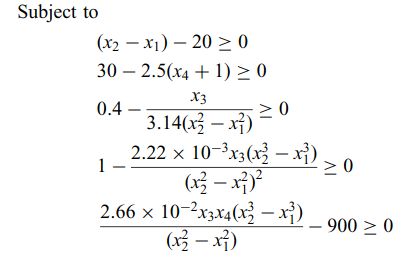

Results: 
Pareto front:

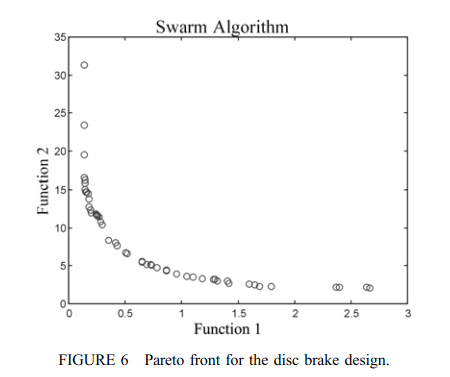

In [200]:
#data generation: 
 
def objective_functions(tensor):
    x1, x2, x3, x4 = tensor[0]
    f1 = 4.9e-5 * (x2**2 - x1**2) * (x4 - 1)
    f2 = 9.82e6 * (x2**2 - x1**2) / (x3 * x4 * (x2**3 - x1**3))
    return torch.tensor([[-f1, -f2]])  # Negate the objectives for minimization

#bounds definition:
parameter_bounds = torch.tensor([[  55.,   75., 1000.,    2.], [  80.,  110., 3000.,   20.]], dtype=torch.float64)

def get_initial_dataset(bounds: torch.Tensor, num_points: int = 2):
    """
    Generates an initial dataset for the SingleTaskGP.

    Parameters:
    bounds (torch.Tensor): A 2 x d tensor specifying the lower and upper bounds for each dimension.
    num_points (int): Number of points to sample. Default is 10.

    Returns:
    train_X (torch.Tensor): A n x d tensor of training features.
    train_Y (torch.Tensor): A n x m tensor of training observations.
    """
    # Ensure the bounds are of float type
    bounds = bounds.float()

    # Create a grid of points within the bounds
    dim = bounds.size(1)
    train_X = torch.zeros(num_points, dim)

    # Calculate the step size for each dimension
    steps = (bounds[1] - bounds[0]) / (num_points - 1)

    # Generate points within the bounds
    for i in range(num_points):
        for j in range(dim):
            train_X[i, j] = bounds[0, j] + i * steps[j]

    # Evaluate the objective functions for each point
    train_Y = torch.zeros(num_points, 2)  # Assuming there are 2 objective functions
    for i in range(num_points):
        train_Y[i] = objective_functions(train_X[i].unsqueeze(0))

    train_X = train_X.to(dtype=torch.float64)
    train_Y = train_Y.to(dtype=torch.float64)

    return train_X, train_Y   


In [201]:

def plot_train_Y(train_Y):
    """
    Plots the training observations to visualize the Pareto front.

    Parameters:
    train_Y (torch.Tensor): A n x m tensor of training observations.
    """
    # Convert train_Y to numpy for plotting
    train_Y_np = -train_Y.numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(train_Y_np[:, 0], train_Y_np[:, 1], c='blue', marker='o')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.title('Training Observations')
    plt.grid(True)
    plt.show()

In [202]:
#model initiation

#here I will use a multi-output singletaskGP, since the objectives all come from the same training data and are independent (at least I assume it for now)

train_X, train_Y = get_initial_dataset(parameter_bounds, num_points=2)

print(train_X, train_Y)

train_X = train_X.to(dtype=torch.float64)
train_Y = train_Y.to(dtype=torch.float64)

model = SingleTaskGP(train_X=train_X, train_Y=train_Y, input_transform=Normalize(d=4, bounds=parameter_bounds), outcome_transform=Standardize(m=2))

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model) 

mll = fit_gpytorch_model(mll)

tensor([[5.5000e+01, 7.5000e+01, 1.0000e+03, 2.0000e+00],
        [8.0000e+01, 1.1000e+02, 3.0000e+03, 2.0000e+01]], dtype=torch.float64) tensor([[ -0.1274, -49.9648],
        [ -5.3067,  -1.1391]], dtype=torch.float64)


In [203]:
model_2 = SingleTaskGP(train_X=train_X, train_Y=train_Y*0.7, input_transform=Normalize(d=4, bounds=parameter_bounds), outcome_transform=Standardize(m=2))

mll_2 = ExactMarginalLogLikelihood(likelihood=model_2.likelihood, model=model_2) 

mll_2 = fit_gpytorch_model(mll_2)

In [208]:
print(train_Y.shape)

torch.Size([2, 2])


In [204]:
from gpytorch.mlls import SumMarginalLogLikelihood
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
import torch
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.models import GP
from gpytorch.distributions import MultivariateNormal
from gpytorch.lazy import PsdSumLazyTensor
from gpytorch.likelihoods import LikelihoodList
from torch.nn import ModuleList
from botorch.acquisition.multi_objective.logei import qLogNoisyExpectedHypervolumeImprovement


In [226]:
class RGPE(GP, GPyTorchModel):
    """
    Rank-weighted GP ensemble. Note: this class inherits from GPyTorchModel which provides an
        interface for GPyTorch models in botorch.
    """

    def __init__(self, models, weights, num_outputs):
        super().__init__()
        self.models = ModuleList(models)
        for m in models:
            if not hasattr(m, "likelihood"):
                raise ValueError(
                    "RGPE currently only supports models that have a likelihood (e.g. ExactGPs)"
                )
        self.likelihood = LikelihoodList(*[m.likelihood for m in models])
        self.weights = weights
        self._num_outputs = num_outputs
        self.to(weights)

    def forward(self, x):
        x = x.double()
        weighted_means = []
        weighted_covars = []
        # filter model with zero weights
        # weights on covariance matrices are weight**2
        non_zero_weight_indices = (self.weights**2 > 0).nonzero()
        non_zero_weights = self.weights[non_zero_weight_indices]
        # re-normalize
        non_zero_weights /= non_zero_weights.sum()

        for non_zero_weight_idx in range(non_zero_weight_indices.shape[0]):
            raw_idx = non_zero_weight_indices[non_zero_weight_idx].item()
            model = self.models[raw_idx]
            posterior = model.posterior(x)
            # unstandardize predictions
            #posterior_mean = posterior.mean.squeeze(-1) * model.outcome_transform.stdvs + model.outcome_transform.means
            #posterior_cov = posterior.mvn.lazy_covariance_matrix * model.outcome_transform.stdvs.pow(2)
            
            #stdvs = model.outcome_transform.stdvs.squeeze(0)
            # Number of points sampled
            #n = x.shape[0]
            # Number of output dimensions
            #d = self._num_outputs
            # Create the scaling matrix
            #scaling_matrix = torch.kron(torch.eye(n), torch.diag(stdvs))
            #scaling_matrix = scaling_matrix.double() 
           # posterior_cov = scaling_matrix @ posterior.mvn.lazy_covariance_matrix @ scaling_matrix.t()

            # apply weight
            weight = non_zero_weights[non_zero_weight_idx]
            weighted_means.append(weight * posterior.mean)
            weighted_covars.append( posterior.mvn.lazy_covariance_matrix * weight**2)
        # set mean and covariance to be the rank-weighted sum the means and covariances of the
        # base models and target model
        mean_x = torch.stack(weighted_means).sum(dim=0)
        print(f"weighted_means: {weighted_means}")
        covar_x = PsdSumLazyTensor(*weighted_covars)
        print(f"weighted_covars: {weighted_covars}")
        print(mean_x, covar_x)
        print("test")
        return MultivariateNormal(mean_x, covar_x)

In [228]:
rgpe = RGPE(models=[model, model_2], weights=torch.tensor([0.5, 0.5], dtype=torch.float64), num_outputs=2)

acq_function = qLogNoisyExpectedHypervolumeImprovement(model=rgpe, 
                                                            ref_point=[0, 0], 
                                                            X_baseline=train_X,
                                                            prune_baseline=False)
        

candidate, acq_value = optimize_acqf(
acq_function=acq_function,
bounds=parameter_bounds,
q=1,
num_restarts=40,
raw_samples=512
        )


weighted_means: [tensor([[ -0.2082, -23.6205],
        [ -2.5089,  -1.9314]], dtype=torch.float64), tensor([[ -0.1457, -16.5343],
        [ -1.7562,  -1.3520]], dtype=torch.float64)]
weighted_covars: [<linear_operator.operators.block_diag_linear_operator.BlockDiagLinearOperator object at 0x0000018AEAF9D900>, <linear_operator.operators.block_diag_linear_operator.BlockDiagLinearOperator object at 0x0000018AEAF9FC40>]
tensor([[ -0.3539, -40.1548],
        [ -4.2651,  -3.2834]], dtype=torch.float64) <linear_operator.operators.psd_sum_linear_operator.PsdSumLinearOperator object at 0x0000018AEAF9FBB0>
test


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [ ]:
def objective_functions(tensor):
    x1, x2, x3, x4 = tensor[0]
    f1 = 4.9e-5 * (x2**2 - x1**2) * (x4 - 1)
    f2 = 9.82e6 * (x2**2 - x1**2) / (x3 * x4 * (x2**3 - x1**3))
    return torch.tensor([[-f1, -f2]])  # Negate the objectives for minimization

#bounds definition:
parameter_bounds = torch.tensor([[  55.,   75., 1000.,    2.], [  80.,  110., 3000.,   20.]], dtype=torch.float64)

def get_initial_dataset(bounds: torch.Tensor, num_points: int = 10):
    """
    Generates an initial dataset for the SingleTaskGP.

    Parameters:
    bounds (torch.Tensor): A 2 x d tensor specifying the lower and upper bounds for each dimension.
    num_points (int): Number of points to sample. Default is 10.

    Returns:
    train_X (torch.Tensor): A n x d tensor of training features.
    train_Y (torch.Tensor): A n x m tensor of training observations.
    """
    # Ensure the bounds are of float type
    bounds = bounds.float()

    # Create a grid of points within the bounds
    dim = bounds.size(1)
    train_X = torch.zeros(num_points, dim)

    # Calculate the step size for each dimension
    steps = (bounds[1] - bounds[0]) / (num_points - 1)

    # Generate points within the bounds
    for i in range(num_points):
        for j in range(dim):
            train_X[i, j] = bounds[0, j] + i * steps[j]

    # Evaluate the objective functions for each point
    train_Y = torch.zeros(num_points, 2)  # Assuming there are 2 objective functions
    for i in range(num_points):
        train_Y[i] = objective_functions(train_X[i].unsqueeze(0))

    train_X = train_X.to(dtype=torch.float64)
    train_Y = train_Y.to(dtype=torch.float64)

    return train_X, train_Y   


#model initiation

#here I will use a multi-output singletaskGP, since the objectives all come from the same training data and are independent (at least I assume it for now)

train_X, train_Y = get_initial_dataset(parameter_bounds, num_points=7)

print(train_X, train_Y)

model = SingleTaskGP(train_X=train_X, train_Y=train_Y, input_transform=Normalize(d=4, bounds=parameter_bounds), outcome_transform=Standardize(m=2))

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model) 

mll = fit_gpytorch_model(mll)

posterior = model.posterior(train_X)

acq_function = qLogNoisyExpectedHypervolumeImprovement(model=model, X_baseline=train_X, ref_point=torch.tensor([0.0, 0.0], dtype=torch.float64))


candidate, acq_value = optimize_acqf(
    acq_function=acq_function,
    bounds=parameter_bounds,
    q=1,
    num_restarts=40,
    raw_samples=512,
        )

In [145]:
posterior = model.posterior(train_X)

print(posterior)



In [147]:
posterior.variance

tensor([[  3.0466, 270.7528],
        [  3.0466, 270.7528]], dtype=torch.float64, grad_fn=<CloneBackward0>)

In [122]:
posterior.mvn.lazy_covariance_matrix.evaluate()

tensor([[3.0466e+00, 3.7685e-05, 0.0000e+00, 0.0000e+00],
        [3.7685e-05, 3.0466e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.7075e+02, 3.3491e-03],
        [0.0000e+00, 0.0000e+00, 3.3491e-03, 2.7075e+02]], dtype=torch.float64,
       grad_fn=<MatmulBackward>)

In [124]:
stdv_matrix = torch.diag(stdvs)

In [125]:
print(stdv_matrix)

tensor([[ 3.6623,  0.0000],
        [ 0.0000, 34.5250]], dtype=torch.float64)


In [93]:
print(posterior.mvn.lazy_covariance_matrix.shape)

torch.Size([20, 20])


In [133]:
import torch

# Example covariance matrix (for general case)
cov = posterior.mvn.lazy_covariance_matrix

# Example standard deviations
stdvs = model.outcome_transform.stdvs.squeeze(0)

# Number of points sampled
n = 2

# Number of output dimensions
d = len(stdvs)

# Create the scaling matrix
scaling_matrix = torch.kron(torch.eye(n), torch.diag(stdvs))

# Unstandardize the covariance matrix
unstandardized_cov = scaling_matrix @ cov @ scaling_matrix.T

In [134]:
print(unstandardized_cov)

tensor([[4.0863e+01, 4.7650e-03, 0.0000e+00, 0.0000e+00],
        [4.7650e-03, 3.6315e+03, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.6315e+03, 4.2347e-01],
        [0.0000e+00, 0.0000e+00, 4.2347e-01, 3.2273e+05]], dtype=torch.float64,
       grad_fn=<MmBackward0>)


In [126]:
unstandardized_cov = stdv_matrix @ cov.view(2, 2, 2, 2) @ stdv_matrix.T

AttributeError: Unknown attribute view for BlockDiagLinearOperator

In [71]:
weight = torch.tensor(0.4)

In [72]:
weighted_mean = posterior.mean * weight 

In [79]:
from gpytorch.distributions import MultivariateNormal

In [73]:
print(weighted_mean)

tensor([[ -0.0513, -19.7806],
        [ -0.1693,  -8.0188],
        [ -0.3124,  -4.0663],
        [ -0.4801,  -2.6432],
        [ -0.6756,  -1.7484],
        [ -0.8999,  -1.2650],
        [ -1.1553,  -0.9378],
        [ -1.4423,  -0.7319],
        [ -1.7655,  -0.5554],
        [ -2.1220,  -0.4840]], dtype=torch.float64, grad_fn=<MulBackward0>)


In [77]:
cov = posterior.mvn.lazy_covariance_matrix
print(cov)

In [78]:
weighted_cov = cov * weight

print(weighted_cov)

In [80]:
MultivariateNormal(weighted_mean, weighted_cov) 

MultivariateNormal(loc: torch.Size([10, 2]))

In [48]:
num_samples = 10

from botorch.sampling.normal import SobolQMCNormalSampler
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_samples]))
base_f_samps = sampler(posterior).squeeze(-1).squeeze(-1)


In [51]:
print(train_Y.shape)

torch.Size([10, 2])


In [54]:
print(base_f_samps.shape)

torch.Size([10, 10, 2])


In [53]:
print(base_f_samps)

tensor([[[ -0.1062, -49.0597],
         [ -0.3964, -20.5315],
         [ -0.8015, -11.7879],
         [ -1.1748,  -6.6452],
         [ -1.6819,  -4.7103],
         [ -2.2581,  -2.0896],
         [ -2.9032,  -2.8613],
         [ -3.5878,  -0.9898],
         [ -4.3823,  -2.4178],
         [ -5.3205,  -2.9607]],

        [[ -0.1370, -51.1381],
         [ -0.4307, -19.7059],
         [ -0.7770,  -7.9404],
         [ -1.2083,  -6.7307],
         [ -1.6914,  -3.7425],
         [ -2.2451,  -4.4813],
         [ -2.8862,  -2.3212],
         [ -3.6499,  -1.9609],
         [ -4.4449,  -1.0305],
         [ -5.2950,  -1.0145]],

        [[ -0.1472, -47.0243],
         [ -0.4228, -21.2015],
         [ -0.7491,  -9.7611],
         [ -1.1891,  -7.7572],
         [ -1.7139,  -3.1642],
         [ -2.2341,  -3.8966],
         [ -2.8926,  -4.1801],
         [ -3.6096,  -1.4041],
         [ -4.4261,  -2.0484],
         [ -5.2877,  -2.0724]],

        [[ -0.1233, -49.6468],
         [ -0.4395, -18.2735],
  

In [7]:
print(model.posterior(train_X).mvn.lazy_covariance_matrix)

In [14]:
dict = model.state_dict()

dict.update

<class 'collections.OrderedDict'>


In [57]:
import torch

class MultiObjectiveRankingLoss:
    def get_pareto_dominance(self, point_1, point_2):
        # Check if point_1 dominates point_2
        dominates = (point_1 <= point_2).all() and (point_1 < point_2).any()
        
        if dominates:
            return 1  # point_1 dominates point_2
        
        # Check if point_2 dominates point_1
        dominated = (point_2 <= point_1).all() and (point_2 < point_1).any()
        
        if dominated:
            return -1  # point_2 dominates point_1
        
        return 0  # Neither point dominates the other
    
    def compute_ranking_loss(self, target_f_samples, true_train_Y):
        # Check if target_f_samples and true_train_Y have the same shape
        if target_f_samples.shape != true_train_Y.shape:
            raise ValueError("The shapes of the target_f_samples and true_train_Y must be the same.")

        n, d = target_f_samples.shape
        ranking_loss = 0

        # Iterate over all pairs of training examples
        for i in range(n):
            for j in range(i + 1, n):
                    # Get the predicted and true values for the pair (i, j)
                    pred_i, pred_j = target_f_samples[i], target_f_samples[j]
                    true_i, true_j = true_train_Y[i], true_train_Y[j]

                    # Compute Pareto dominance for both predicted and true values
                    pred_dominance = self.get_pareto_dominance(pred_i, pred_j)
                    #print("predict")
                    #print(pred_i, pred_j)
                    #print(pred_dominance)
                    true_dominance = self.get_pareto_dominance(true_i, true_j)
                    #print("true")
                    #print(true_i, true_j)
                    #print(true_dominance)

                    # Increment ranking loss if the predicted dominance doesn't match the true dominance
                    if pred_dominance != true_dominance:
                        ranking_loss += 1
                        print(ranking_loss)

                    #print("next Point")

        return ranking_loss

In [59]:
# Create an instance of the class
loss_calculator = MultiObjectiveRankingLoss()

# Example data (three-dimensional multi-objective example)
target_f_samples = torch.tensor([[-1686.9345529751338, -9.694705981882207, -0.10764831622708651], [-1689.7025038207535, -10.155442392061087, -0.106731646573131], [-1689.7934184940452, -10.381630816142268, -0.12730377132127407], [-1673.3847492877574, -9.59549149256099, -0.08544080465945393], [-1673.2530928970825, -8.017307462006844, -0.1713744902330736]])  # Predicted values
true_train_Y = torch.tensor([[-1667.71484375, -10.083209037780762, -0.2165755033493042], [-1672.8330078125, -10.222806930541992, -0.08668578416109085], [-1680.0157470703125, -9.050023078918457, -0.10142767429351807], [-1687.068603515625, -10.007349014282227, -0.06876835972070694], [-1697.1553955078125, -9.698583602905273, -0.03054405003786087]])       # True values

# Test the get_pareto_dominance function with three-dimensional points
point_1 = torch.tensor([1.0, 2.0, 3.0])
point_2 = torch.tensor([2.0, 1.0, 0.5])
point_3 = torch.tensor([3.0, 3.0, 1.0])
print("Pareto dominance (point_1 vs point_2):", loss_calculator.get_pareto_dominance(point_1, point_2))  # Expected: 0 (neither dominates)
print("Pareto dominance (point_1 vs point_3):", loss_calculator.get_pareto_dominance(point_1, point_3))  # Expected: 0 (neither dominates)
print("Pareto dominance (point_2 vs point_3):", loss_calculator.get_pareto_dominance(point_2, point_3))  # Expected: 1 (point_2 dominates)

# Test the compute_ranking_loss function
ranking_loss = loss_calculator.compute_ranking_loss(target_f_samples, true_train_Y)
print("Computed ranking loss:", ranking_loss)  # Expected output depends on the comparison

# For the example provided, you should be able to manually verify if the loss is computed correctly.

Pareto dominance (point_1 vs point_2): 0
Pareto dominance (point_1 vs point_3): 0
Pareto dominance (point_2 vs point_3): 1
1
2
3
4
5
Computed ranking loss: 5


In [12]:
loss_calculator = MultiObjectiveRankingLoss()

# Example data (simple multi-objective example)
target_f_samples = torch.tensor([[1.0, 2.0], [2.0, 1.0], [3.0, 3.0]])  # Predicted values
true_train_Y = torch.tensor([[1.5, 2.5], [2.5, 1.5], [2.0, 2.0]])       # True values

# Test the get_pareto_dominance function
point_1 = torch.tensor([1.0, 2.0])
point_2 = torch.tensor([2.0, 1.0])
point_3 = torch.tensor([1.5, 2.5])
print("Pareto dominance (point_1 vs point_2):", loss_calculator.get_pareto_dominance(point_1, point_2))  # Expected: 0 (neither dominates)
print("Pareto dominance (point_1 vs point_3):", loss_calculator.get_pareto_dominance(point_1, point_3))  # Expected: 1 (point_3 dominates)

# Test the compute_ranking_loss function
ranking_loss = loss_calculator.compute_ranking_loss(target_f_samples, true_train_Y)
print("Computed ranking loss:", ranking_loss)  # Expected output depends on the comparison

# For the example provided, you should be able to manually verify if the loss is computed correctly.

Pareto dominance (point_1 vs point_2): 0
Pareto dominance (point_1 vs point_3): 1
Computed ranking loss: 4


In [11]:
#import pkl dataset: 

path = "C:\\Users\\Moritz\\Documents\\Masterarbeit_GAMI\\BasicGP_RS\\smart_doe_bayesian_optimization\\data_export\\multi_singletaskgp_data_export\\20240812_1324_BOMOGP_TL_Opt_var_fac_0_0\\20240812_1324_BOMOGP_TL_Opt_var_fac_0_0_combined_dataset_info.pkl"

import pickle

# Load the pickle file
with open(path, 'rb') as file:
    data = pickle.load(file)

# Print the loaded dictionaries
for key, value in data.items():
    print(f"Dictionary Key: {key}")
    print(f"Dictionary Value: {value}\n")


Dictionary Key: model_info
Dictionary Value: OrderedDict([('models.0.likelihood.noise_covar.raw_noise', tensor([0.0067], dtype=torch.float64)), ('models.0.likelihood.noise_covar.noise_prior.concentration', tensor(1.1000, dtype=torch.float64)), ('models.0.likelihood.noise_covar.noise_prior.rate', tensor(0.0500, dtype=torch.float64)), ('models.0.likelihood.noise_covar.raw_noise_constraint.lower_bound', tensor(1.0000e-04, dtype=torch.float64)), ('models.0.likelihood.noise_covar.raw_noise_constraint.upper_bound', tensor(inf, dtype=torch.float64)), ('models.0.mean_module.raw_constant', tensor(-0.1984, dtype=torch.float64)), ('models.0.covar_module.raw_outputscale', tensor(-0.2035, dtype=torch.float64)), ('models.0.covar_module.base_kernel.raw_lengthscale', tensor([[-0.2703, -0.0853, -0.1118, -0.6366, -0.3437]], dtype=torch.float64)), ('models.0.covar_module.base_kernel.lengthscale_prior.concentration', tensor(3., dtype=torch.float64)), ('models.0.covar_module.base_kernel.lengthscale_prior.r

In [122]:
for kernel in model.covar_module.base_kernel.lengthscale:
    print(kernel)

tensor([[0.6931, 0.6931, 0.6931, 0.6931]], dtype=torch.float64,
       grad_fn=<UnbindBackward0>)
tensor([[0.6931, 0.6931, 0.6931, 0.6931]], dtype=torch.float64,
       grad_fn=<UnbindBackward0>)


In [123]:
print(model.mean_module.constant)

Parameter containing:
tensor([0., 0.], dtype=torch.float64, requires_grad=True)


In [124]:
#fitting the model

fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
    (input_transform): Normalize()
  )
)

In [125]:
print(model.mean_module.constant)

Parameter containing:
tensor([-0.2088, -0.5427], dtype=torch.float64, requires_grad=True)


In [126]:
for kernel in model.covar_module.base_kernel.lengthscale:
    print(kernel)

tensor([[0.7869, 0.7869, 0.7869, 0.7869]], dtype=torch.float64,
       grad_fn=<UnbindBackward0>)
tensor([[0.4607, 0.4607, 0.4607, 0.4607]], dtype=torch.float64,
       grad_fn=<UnbindBackward0>)


In [127]:
model.eval()
with torch.no_grad():
    predictions = model.posterior(train_X).mean
    print("Predictions on training data:")
    print(predictions)

Predictions on training data:
tensor([[ -0.1283, -49.4515],
        [ -0.4232, -20.0471],
        [ -0.7809, -10.1657],
        [ -1.2003,  -6.6080],
        [ -1.6890,  -4.3711],
        [ -2.2496,  -3.1624],
        [ -2.8882,  -2.3445],
        [ -3.6058,  -1.8297],
        [ -4.4138,  -1.3884],
        [ -5.3050,  -1.2101]], dtype=torch.float64)


In [128]:
def perform_optimization_step(model, train_X, train_Y, bounds, num_restarts=10, raw_samples=512):

    model.eval()

    qNEHVI = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=train_Y.min(dim=0).values - 0.1,
        X_baseline=train_X
    )

    # Optimize the acquisition function to find the next point to sample
    new_X, acq_func_value = optimize_acqf(
        acq_function=qNEHVI,
        bounds=bounds,
        q=1,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        options={"batch_limit": 5, "maxiter": 200},
    )

    print(f"Acquisition function value:{acq_func_value}")
    
    return new_X, acq_func_value

In [129]:
new_X, acq_func_value = perform_optimization_step(model, train_X, train_Y, parameter_bounds)
print(new_X)
new_Y = objective_functions(new_X)
print(new_Y)



Acquisition function value:16.16283041727844
tensor([[  60.1387,   75.6928, 2389.3547,    5.1235]], dtype=torch.float64)
tensor([[-0.4269, -7.8398]], dtype=torch.float64)


In [130]:
print(model.train_targets)
print(model.train_targets.shape)
print(model.train_inputs)
print(model.train_inputs[0].shape)

tensor([[ 1.2209,  1.0517,  0.8486,  0.6090,  0.3305,  0.0106, -0.3532, -0.7633,
         -1.2223, -1.7326],
        [-2.6406, -0.6209, -0.0264,  0.2358,  0.3751,  0.4578,  0.5108,  0.5466,
          0.5718,  0.5901]], dtype=torch.float64)
torch.Size([2, 10])
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.1111, 0.1111, 0.1111, 0.1111],
         [0.2222, 0.2222, 0.2222, 0.2222],
         [0.3333, 0.3333, 0.3333, 0.3333],
         [0.4444, 0.4444, 0.4444, 0.4444],
         [0.5556, 0.5556, 0.5556, 0.5556],
         [0.6667, 0.6667, 0.6667, 0.6667],
         [0.7778, 0.7778, 0.7778, 0.7778],
         [0.8889, 0.8889, 0.8889, 0.8889],
         [1.0000, 1.0000, 1.0000, 1.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000],
         [0.1111, 0.1111, 0.1111, 0.1111],
         [0.2222, 0.2222, 0.2222, 0.2222],
         [0.3333, 0.3333, 0.3333, 0.3333],
         [0.4444, 0.4444, 0.4444, 0.4444],
         [0.5556, 0.5556, 0.5556, 0.5556],
         [0.6667, 0.6667, 0.6667, 0.6667],
      

In [131]:
model = model.condition_on_observations(new_X, new_Y)
print(model.train_targets)
print(model.train_targets.shape)
print(model.train_inputs)
print(model.train_inputs[0].shape)

tensor([[ 1.2209,  1.0517,  0.8486,  0.6090,  0.3305,  0.0106, -0.3532, -0.7633,
         -1.2223, -1.7326,  1.0501],
        [-2.6406, -0.6209, -0.0264,  0.2358,  0.3751,  0.4578,  0.5108,  0.5466,
          0.5718,  0.5901,  0.1468]], dtype=torch.float64)
torch.Size([2, 11])
[tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.1111e-01, 1.1111e-01, 1.1111e-01, 1.1111e-01],
         [2.2222e-01, 2.2222e-01, 2.2222e-01, 2.2222e-01],
         [3.3333e-01, 3.3333e-01, 3.3333e-01, 3.3333e-01],
         [4.4444e-01, 4.4444e-01, 4.4444e-01, 4.4444e-01],
         [5.5556e-01, 5.5556e-01, 5.5556e-01, 5.5556e-01],
         [6.6667e-01, 6.6667e-01, 6.6667e-01, 6.6667e-01],
         [7.7778e-01, 7.7778e-01, 7.7778e-01, 7.7778e-01],
         [8.8889e-01, 8.8889e-01, 8.8889e-01, 8.8889e-01],
         [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
         [6.0139e+01, 7.5693e+01, 2.3894e+03, 5.1235e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1

In [136]:
print(model)

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
  (outcome_transform): Standardize()
  (input_transform): Normalize()
)


In [132]:
transformed_Y , _= model.outcome_transform(new_Y)
print(transformed_Y)

tensor([[1.0501, 0.1468]], dtype=torch.float64)


In [ ]:
transformed_X = model.input_transform(new_X)

In [63]:
print(transformed_X)

tensor([[0.7073, 0.0401, 0.1629, 0.1882]], dtype=torch.float64)


In [72]:
transformed_Y , _= model.outcome_transform(new_Y)

In [73]:
print(transformed_Y)

tensor([[ 1.2255, -0.1479]], dtype=torch.float64)


In [64]:
print(model.train_inputs)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.1111, 0.1111, 0.1111, 0.1111],
         [0.2222, 0.2222, 0.2222, 0.2222],
         [0.3333, 0.3333, 0.3333, 0.3333],
         [0.4444, 0.4444, 0.4444, 0.4444],
         [0.5556, 0.5556, 0.5556, 0.5556],
         [0.6667, 0.6667, 0.6667, 0.6667],
         [0.7778, 0.7778, 0.7778, 0.7778],
         [0.8889, 0.8889, 0.8889, 0.8889],
         [1.0000, 1.0000, 1.0000, 1.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000],
         [0.1111, 0.1111, 0.1111, 0.1111],
         [0.2222, 0.2222, 0.2222, 0.2222],
         [0.3333, 0.3333, 0.3333, 0.3333],
         [0.4444, 0.4444, 0.4444, 0.4444],
         [0.5556, 0.5556, 0.5556, 0.5556],
         [0.6667, 0.6667, 0.6667, 0.6667],
         [0.7778, 0.7778, 0.7778, 0.7778],
         [0.8889, 0.8889, 0.8889, 0.8889],
         [1.0000, 1.0000, 1.0000, 1.0000]]], dtype=torch.float64),)


In [76]:
print(model.train_targets)

tensor([[ 1.2209,  1.0517,  0.8486,  0.6090,  0.3305,  0.0106, -0.3532, -0.7633,
         -1.2223, -1.7326,  1.9924],
        [-2.6406, -0.6209, -0.0264,  0.2358,  0.3751,  0.4578,  0.5108,  0.5466,
          0.5718,  0.5901,  0.6557]], dtype=torch.float64)


In [50]:
print(model.train_inputs)

[tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.1111e-01, 1.1111e-01, 1.1111e-01, 1.1111e-01],
         [2.2222e-01, 2.2222e-01, 2.2222e-01, 2.2222e-01],
         [3.3333e-01, 3.3333e-01, 3.3333e-01, 3.3333e-01],
         [4.4444e-01, 4.4444e-01, 4.4444e-01, 4.4444e-01],
         [5.5556e-01, 5.5556e-01, 5.5556e-01, 5.5556e-01],
         [6.6667e-01, 6.6667e-01, 6.6667e-01, 6.6667e-01],
         [7.7778e-01, 7.7778e-01, 7.7778e-01, 7.7778e-01],
         [8.8889e-01, 8.8889e-01, 8.8889e-01, 8.8889e-01],
         [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
         [5.5000e+01, 7.8191e+01, 1.8917e+03, 1.3045e+01]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.1111e-01, 1.1111e-01, 1.1111e-01, 1.1111e-01],
         [2.2222e-01, 2.2222e-01, 2.2222e-01, 2.2222e-01],
         [3.3333e-01, 3.3333e-01, 3.3333e-01, 3.3333e-01],
         [4.4444e-01, 4.4444e-01, 4.4444e-01, 4.4444e-01],
         [5.5556e-01, 5.5556e-01, 5.5556e-01, 5.5556e

In [16]:
import torch
import botorch
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf

def generate_initial_data(n_points):
    train_X = torch.linspace(0, 1, n_points, dtype=torch.float64).unsqueeze(-1)
    train_Y = torch.sin(train_X * (2 * torch.pi))
    return train_X, train_Y

train_X, train_Y = generate_initial_data(n_points=4)

parameter_bounds = torch.tensor([[0.], [1.]], dtype=torch.float64)

model = SingleTaskGP(train_X=train_X, train_Y=train_Y, outcome_transform=Standardize(m=1), input_transform=Normalize(d=1))

print(train_X)
print(train_Y)

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model) 
fit_gpytorch_mll(mll)

print(model.train_targets)
print(model.train_targets.shape)
print(model.train_inputs)
print(model.train_inputs[0].shape)

acqf = botorch.acquisition.UpperConfidenceBound(model, beta=0.1)

# Optimize the acquisition function
candidate, acq_value = optimize_acqf(
    acq_function=acqf,
    bounds=parameter_bounds,
    q=1,
    num_restarts=5,
    raw_samples=20,
)

next_X = candidate

next_Y = torch.sin(next_X * (2 * torch.pi))

print(next_X)
print(next_Y)

# train_X = torch.cat([train_X, next_X])
# train_Y = torch.cat([train_Y, next_Y])

# print(train_X)
# print(train_Y)

# print(train_X.shape)
# print(train_Y.shape)

# model = SingleTaskGP(train_X=train_X, train_Y=train_Y, outcome_transform=Standardize(m=1), input_transform=Normalize(d=1))

# mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model) 
# fit_gpytorch_mll(mll)

tensor([[0.0000],
        [0.3333],
        [0.6667],
        [1.0000]], dtype=torch.float64)
tensor([[ 0.0000e+00],
        [ 8.6603e-01],
        [-8.6603e-01],
        [-2.4493e-16]], dtype=torch.float64)
tensor([ 1.2585e-16,  1.2247e+00, -1.2247e+00, -2.2053e-16],
       dtype=torch.float64)
torch.Size([4])
(tensor([[0.0000],
        [0.3333],
        [0.6667],
        [1.0000]], dtype=torch.float64),)
torch.Size([4, 1])
tensor([[0.2881]], dtype=torch.float64)
tensor([[0.9715]], dtype=torch.float64)


In [2]:
import torch
import botorch
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf


model = SingleTaskGP(train_X=torch.Tensor([]).reshape(0,2), train_Y=torch.Tensor([]).reshape(0,2))

c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\models\utils\assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


In [151]:
import torch
import botorch
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf

def generate_initial_data(n_points):
    train_X = torch.linspace(0, 6, n_points, dtype=torch.float64).unsqueeze(-1)
    train_Y = torch.sin(train_X * (2 * torch.pi) / 6)
    return train_X, train_Y

train_X, train_Y = generate_initial_data(n_points=5)

parameter_bounds = torch.tensor([[0.], [6.]], dtype=torch.float64)

model = SingleTaskGP(train_X=train_X, train_Y=train_Y, input_transform=Normalize(d=1, bounds=parameter_bounds), outcome_transform=Standardize(m=1))

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model) 
fit_gpytorch_mll(mll)

print(f"Training targets: {model.train_targets}")
print(f"Training targets shape: {model.train_targets.shape}")
print(f"Training inputs: {model.train_inputs}")
print(f"Training inputs shape: {model.train_inputs[0].shape}")

acqf = botorch.acquisition.UpperConfidenceBound(model, beta=0.1)

# Optimize the acquisition function
candidate, acq_value = optimize_acqf(
    acq_function=acqf,
    bounds=parameter_bounds,
    q=1,
    num_restarts=5,
    raw_samples=20,
)

next_X = candidate
next_Y = torch.sin(next_X * (2 * torch.pi) / 6)

print(f"Next evaluation point (X): {next_X}")
print(f"Next evaluation point (Y): {next_Y}")

print(f"Transformed next X: {model.input_transform(next_X)}")
print(f"Transformed next Y: {model.outcome_transform(next_Y)}")

model = model.condition_on_observations(next_X, next_Y)

print(f"Updated training targets: {model.train_targets}")
print(f"Updated training targets shape: {model.train_targets.shape}")
print(f"Updated training inputs: {model.train_inputs}")
print(f"Updated training inputs shape: {model.train_inputs[0].shape}")

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model) 
fit_gpytorch_mll(mll)

Training targets: tensor([ 3.1402e-17,  1.4142e+00,  2.0459e-16, -1.4142e+00, -3.1498e-16],
       dtype=torch.float64)
Training targets shape: torch.Size([5])
Training inputs: (tensor([[0.0000],
        [0.2500],
        [0.5000],
        [0.7500],
        [1.0000]], dtype=torch.float64),)
Training inputs shape: torch.Size([5, 1])
Next evaluation point (X): tensor([[1.5639]], dtype=torch.float64)
Next evaluation point (Y): tensor([[0.9978]], dtype=torch.float64)
Transformed next X: tensor([[0.2607]], dtype=torch.float64)
Transformed next Y: (tensor([[1.4110]], dtype=torch.float64), None)
Updated training targets: tensor([ 3.1402e-17,  1.4142e+00,  2.0459e-16, -1.4142e+00, -3.1498e-16,
         1.4110e+00], dtype=torch.float64)
Updated training targets shape: torch.Size([6])
Updated training inputs: [tensor([[0.0000],
        [0.2500],
        [0.5000],
        [0.7500],
        [1.0000],
        [1.5639]], dtype=torch.float64)]
Updated training inputs shape: torch.Size([6, 1])


RuntimeError: The size of tensor a (6) must match the size of tensor b (5) at non-singleton dimension 0

In [231]:
def generate_initial_data(n_points):
    train_X = torch.linspace(0, 6, n_points, dtype=torch.float64).unsqueeze(-1)
    train_Y = torch.sin(train_X * (2 * torch.pi) / 6)
    return train_X, train_Y

train_X, train_Y = generate_initial_data(n_points=5)

print(train_X)
print(train_Y)

tensor([[0.0000],
        [1.5000],
        [3.0000],
        [4.5000],
        [6.0000]], dtype=torch.float64)
tensor([[ 0.0000e+00],
        [ 1.0000e+00],
        [ 1.2246e-16],
        [-1.0000e+00],
        [-2.4493e-16]], dtype=torch.float64)


In [230]:
def perform_optimization(train_X, train_Y, model, bounds, num_iterations: int = 10):
    acq_func_values = []

    for i in range(num_iterations):
        start_time = time.time()  # Start timing

        new_X, acq_func_value = perform_optimization_step(model, train_X, train_Y, bounds)
        acq_func_values.append(acq_func_value)
        new_Y = objective_functions(new_X)
        train_X = torch.cat([train_X, new_X])
        train_Y = torch.cat([train_Y, new_Y])
        print(f"Iteration {i}: {new_X} - {new_Y}")

        # Update the model
        model = SingleTaskGP(
            train_X=train_X, 
            train_Y=train_Y, 
            input_transform=Normalize(d=4, bounds=bounds), 
            outcome_transform=Standardize(m=2)
        )
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        end_time = time.time()  # End timing
        iteration_time = end_time - start_time
        print(f"Iteration {i} took {iteration_time:.4f} seconds")

    return train_X, train_Y, acq_func_values
    

In [178]:
new_train_X, new_train_Y, acq_func_values = perform_optimization(train_X, train_Y, model, parameter_bounds, num_iterations=20)

Acquisition function value:17.01079662445396
Iteration 0: tensor([[  55.6073,   75.4146, 2140.0391,   10.9895]], dtype=torch.float64) - tensor([[-1.2703, -4.2171]], dtype=torch.float64)
Iteration 0 took 5.3739 seconds
Acquisition function value:16.218479468062444
Iteration 1: tensor([[  55.0000,   83.8656, 1383.4189,   14.3237]], dtype=torch.float64) - tensor([[-2.6170, -4.6907]], dtype=torch.float64)
Iteration 1 took 11.9624 seconds
Acquisition function value:22.368296859894258
Iteration 2: tensor([[  61.3451,   75.2688, 2391.8647,    2.7690]], dtype=torch.float64) - tensor([[ -0.1649, -14.4212]], dtype=torch.float64)
Iteration 2 took 10.4564 seconds
Acquisition function value:15.09487646075326
Iteration 3: tensor([[  55.0000,   89.7666, 2455.9836,    2.5163]], dtype=torch.float64) - tensor([[ -0.3740, -14.3588]], dtype=torch.float64)
Iteration 3 took 9.5429 seconds
Acquisition function value:11.479866009110996
Iteration 4: tensor([[  62.6055,   82.5424, 2679.1055,   10.7630]], dtype=

In [179]:
def plot_acquisition_function_values(acq_func_values):
    """
    Plots the acquisition function values over iterations.

    Parameters:
    acq_func_values (list of float): The acquisition function values collected over iterations.
    """
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(acq_func_values, marker='o', linestyle='-', color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('Acquisition Function Value')
    plt.title('Acquisition Function Values Over Iterations')
    plt.grid(True)
    plt.show()

In [180]:
print(new_train_Y.shape)

torch.Size([30, 2])


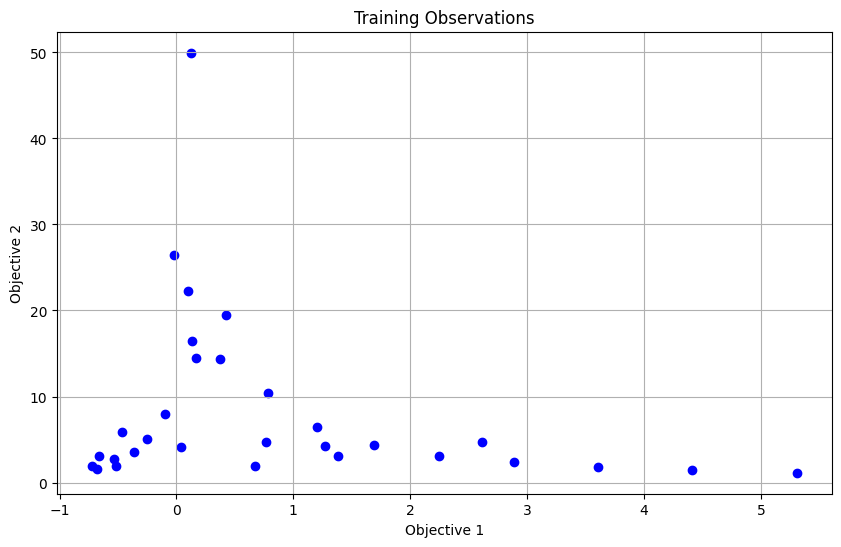

In [181]:
plot_train_Y(new_train_Y)

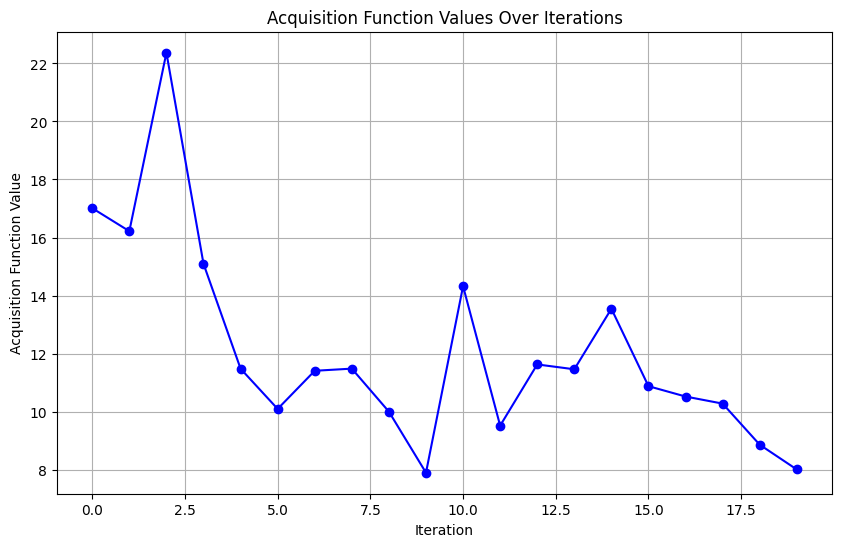

In [182]:
plot_acquisition_function_values(acq_func_values)

In [68]:
print(type(new_train_X))
print(new_train_X)
print(type(new_train_Y))
print(new_train_Y)

<class 'torch.Tensor'>
tensor([[  80.,  110., 1000.,   20.]], dtype=torch.float64)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |     1000 |      5 |             - |             -
     2 |     2000 |      7 |  0.0308596354 |         ideal
     3 |     3000 |     10 |  0.0763449588 |         nadir
     4 |     4000 |     16 |  0.1974336952 |         ideal
     5 |     5000 |     20 |  0.0062085685 |         ideal
     6 |     6000 |     29 |  0.0230250122 |         ideal
     7 |     7000 |     22 |  0.0136230191 |         ideal
     8 |     8000 |     36 |  0.0191493722 |             f
     9 |     9000 |     45 |  0.0145585764 |         ideal
    10 |    10000 |     62 |  0.0129126789 |         ideal
    11 |    11000 |     77 |  0.0079541337 |         nadir
    12 |    12000 |     87 |  0.4522141391 |         nadir
    13 |    13000 |    120 |  0.0311591565 |         ideal
    14 |    14000 |    158 |  0.0035701063 |             f
    15 |    15000 |    197 |  0.0031178981 |             f
    16 |    16000 |    271 |  0.0023005832 |            

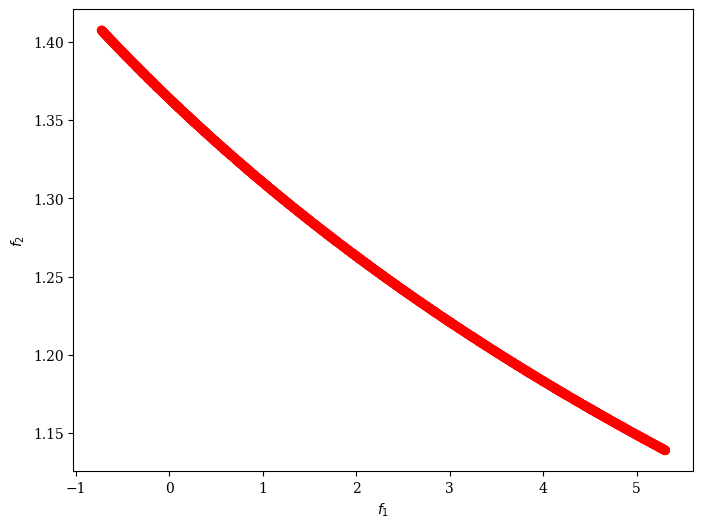

In [186]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.visualization.scatter import Scatter

# Define the objective functions
def f1(x):
    return 4.9e-5 * (x[1]**2 - x[0]**2) * (x[3] - 1)

def f2(x):
    return 9.82e6 * (x[1]**2 - x[0]**2) / (x[2] * x[3] * (x[1]**3 - x[0]**3))

# Define the bounds
bounds = [(55, 80), (75, 110), (1000, 3000), (2, 20)]

# Define the problem class
class MyProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=4, n_obj=2, n_constr=0, xl=np.array([55, 75, 1000, 2]), xu=np.array([80, 110, 3000, 20]))
    
    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = [f1(x), f2(x)]

# Instantiate the problem
problem = MyProblem()

# Define the algorithm
algorithm = NSGA2(pop_size=1000)

# Define the termination criterion
termination = get_termination("n_gen", 1000)

# Perform the optimization
res = minimize(problem, algorithm, termination, seed=1, save_history=True, verbose=True)

# Plot the Pareto front
plot = Scatter()
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

# Print the results
print("Pareto front points:")
for i in range(len(res.F)):
    print(f"f1: {res.F[i][0]}, f2: {res.F[i][1]}, x: {res.X[i]}")
